#### In house price prediction, our primary evaluation metric is RMSLE (Root Mean Squared Logarithmic Error). It is calculated by taking the standard RMSE on the natural logarithm of both the predicted and actual values.
    - Interpretation: Penalizes relative errors. It considers the percentage difference. A $10k error on a $100k home is penalized similarly to a $100k error on a $1M home.
    - Outlier sensitivity: Low. High-priced outliers (e.g., Mansions) do not explode the error metric.
    - Target distribution: Ideal for highly right-skewed targets like home prices.
    - Directional Bias: Slightly penalizes under-predictions more than over-predictions.
Since a buyer's perception of "overpaying" is usually relative to the total value of the home, RMSLE perfectly aligns the model's objective with human intuition.

####  In contrast, RMSE and MAE:
        - Penalize absolute errors.
        - Have an outlier sensitivity that is very high (RMSE) or Moderate (MAE).
        - Give a symmetric penalty.

In [1]:
import pandas as pd
import numpy as np

# 1. Load the Dataset
train_path = "datasets/train.csv"
test_path = "datasets/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop Id from features
train_df = train_df.drop('Id', axis=1)

# ---------------------------------------------------------
# METRIC JUSTIFICATION: RMSLE vs RMSE Example
# ---------------------------------------------------------
print("--- RMSLE vs RMSE Demonstration ---")
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error

# Hypothetical Scenario: $10k error on a Cheap home vs an Expensive home
actuals = [100_000, 1_000_000]
predictions = [110_000, 1_010_000] # $10k error for both

rmse = root_mean_squared_error(actuals, predictions)
rmsle = root_mean_squared_log_error(actuals, predictions)

print(f"Absolute RMSE for both combined: ${rmse:.2f}")
print(f"RMSLE (Relative error): {rmsle:.4f}")
print("RMSLE naturally normalizes the errors across huge price differences.\n")

# ---------------------------------------------------------
# DATA OVERVIEW & BASELINE REPORT
# ---------------------------------------------------------
print("--- Dataset Overview ---")
print(f"Shape (Rows, Columns): {train_df.shape}\n")

# Target Summary
target = train_df['SalePrice']
print("--- Target (SalePrice) Summary ---")
print(f"Mean:   ${target.mean():,.0f}")
print(f"Median: ${target.median():,.0f}")
print(f"Skew:   {target.skew():.2f}")
print()

# Feature Typology
# Exclude the target from the feature count
features = train_df.drop('SalePrice', axis=1)
num_features = features.select_dtypes(include=[np.number]).columns
cat_features = features.select_dtypes(include=['object', 'string']).columns

print("--- Feature Types ---")
print(f"Numeric features:     {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")
print()

# Missing Values Table
print("--- Top 10 Missing Features ---")
missing_counts = features.isnull().sum()
missing_pct = (missing_counts / len(features)) * 100

# Create a DataFrame for easy viewing
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})

# Sort and get top 10
top_missing = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False).head(10)

# Format the percentage for display
top_missing['Percentage'] = top_missing['Percentage'].map('{:.1f}%'.format)

print(top_missing)

--- RMSLE vs RMSE Demonstration ---
Absolute RMSE for both combined: $10000.00
RMSLE (Relative error): 0.0678
RMSLE naturally normalizes the errors across huge price differences.

--- Dataset Overview ---
Shape (Rows, Columns): (1460, 80)

--- Target (SalePrice) Summary ---
Mean:   $180,921
Median: $163,000
Skew:   1.88

--- Feature Types ---
Numeric features:     36
Categorical features: 43

--- Top 10 Missing Features ---
              Missing Count Percentage
PoolQC                 1453      99.5%
MiscFeature            1406      96.3%
Alley                  1369      93.8%
Fence                  1179      80.8%
MasVnrType              872      59.7%
FireplaceQu             690      47.3%
LotFrontage             259      17.7%
GarageType               81       5.5%
GarageYrBlt              81       5.5%
GarageFinish             81       5.5%


#### We notice that the dataset is right (or positively) skewed.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Separate Target and Features
y = np.log1p(train_df['SalePrice']) # Log transform target for RMSLE optimization
X = train_df.drop('SalePrice', axis=1)
X_test_final = test_df.copy()

# Define Feature Groups
# We manually separate them to apply specific preprocessing
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'string']).columns.tolist()

# ---------------------------------------------------------
# CUSTOM IMPUTATION STRATEGY
# ---------------------------------------------------------
# Many features in this dataset have "Meaningful Missingness"
# e.g., NaN in 'PoolQC' means "No Pool", not missing data.

none_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]

# For these, we fill NaN with "None"
for col in none_cols:
    if col in X.columns:
        X[col] = X[col].fillna('None')
        X_test_final[col] = X_test_final[col].fillna('None')

# For GarageYrBlt, if missing, it means no garage. Fill with 0.
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)
X_test_final['GarageYrBlt'] = X_test_final['GarageYrBlt'].fillna(0)

# ---------------------------------------------------------
# PREPROCESSING PIPELINE
# ---------------------------------------------------------

# Numeric Transformer: Impute median for remaining missing (e.g., LotFrontage)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical Transformer:
# 1. Impute 'most_frequent' for true missing values (like Electrical)
# 2. OneHotEncode (handle_unknown='ignore' is crucial for new categories in test)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False returns a dense array/dataframe
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    verbose_feature_names_out=False # Keeps column names clean
).set_output(transform="pandas")

# Fit/Transform Data
# We fit only on training data to avoid data leakage
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_final)

print("--- Preprocessing Complete ---")
print(f"Original Feature Count: {X.shape[1]}")
print(f"Processed Feature Count: {X_processed.shape[1]} (due to One-Hot Encoding)")
print(f"Target Distribution: Mean={y.mean():.2f}, Std={y.std():.2f} (Log Scale)")

--- Preprocessing Complete ---
Original Feature Count: 79
Processed Feature Count: 302 (due to One-Hot Encoding)
Target Distribution: Mean=12.02, Std=0.40 (Log Scale)


#### In the columns that had "Meaningful Missingness", we filled NaN values with 'None'. For the column "GarageYrBlt" if a value is missing, it means no garage. So, we filled with 0.
    Our models will understand these are features and not errors.
 To prevent leakage, the preprocessor is fit only on the training set. The test set is transformed using the training set's statistics (medians/modes).

### We will evaluate two baseline models using K-Fold Cross-Validation:
    Dummy Regressor: Predicts the mean of the training targets for every house. This tells us the "zero-effort" error rate.
    Linear Regression: A simple linear model to see how much improvement we get just by using the features linearly.



Note: Since we already log-transformed the target (y = np.log1p(SalePrice)), calculating RMSE on y is mathematically equivalent to calculating RMSLE on the original prices.



In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# 1. Setup Cross-Validation Strategy
# We use KFold with random_state=0 for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def report_rmsle(model, X, y, name):
    # We use 'neg_root_mean_squared_error' because scikit-learn metrics represent 'scores' (higher is better).
    # RMSE is an error (lower is better), so sklearn returns negative RMSE.
    # We negate it back to get positive RMSE (which corresponds to RMSLE here).
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    rmse_scores = -scores
    print(f"{name}:")
    print(f"  RMSLE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    return rmse_scores.mean()

print("--- Baseline Evaluation (RMSLE) ---")

# 2. Dummy Regressor (Naive Baseline)
dummy = DummyRegressor(strategy='mean')
dummy_score = report_rmsle(dummy, X_processed, y, "Dummy Regressor (Mean)")

# 3. Linear Regression (Simple Baseline)
# OLS without regularization can sometimes overfit if features are collinear,
# but it's a good 'next step' baseline.
lin_reg = LinearRegression()
lin_reg_score = report_rmsle(lin_reg, X_processed, y, "Linear Regression")

# Calculate improvement
improvement = (dummy_score - lin_reg_score) / dummy_score * 100
print(f"\nImprovement over Dummy: {improvement:.1f}%")

--- Baseline Evaluation (RMSLE) ---
Dummy Regressor (Mean):
  RMSLE: 0.3993 ± 0.0244
Linear Regression:
  RMSLE: 0.1602 ± 0.0480

Improvement over Dummy: 59.9%


#### Dummy Regressor:  scores around 0.39. This means if you just guess the average price, you are off by ~40% (log-scale roughly translates to percentage error for small values).
#### Linear Regression: drops significantly, around 0.16. This confirms the features have strong predictive power.

## Model Training
 Let's start with a decision tree.

Best Decision Tree RMSLE: 0.1863
Best Parameters: {'max_depth': None, 'min_samples_leaf': 20}


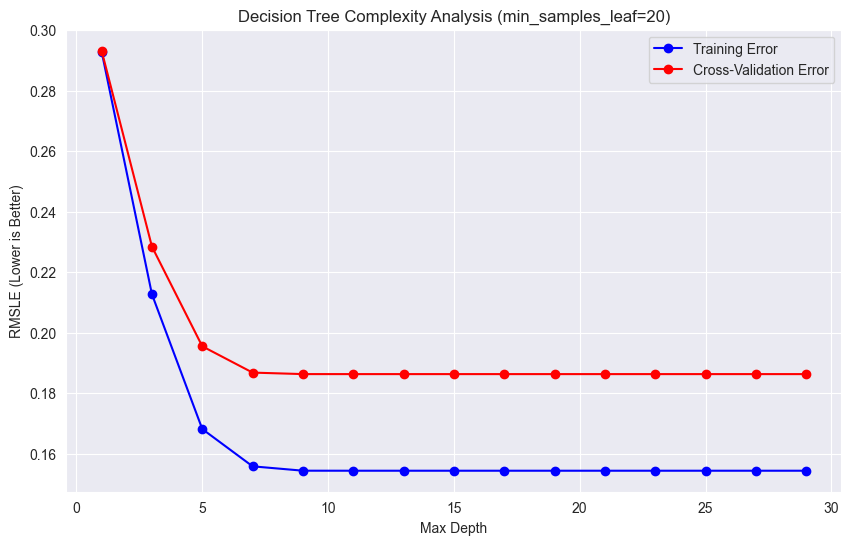

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.tree import DecisionTreeRegressor

# Grid Search for Best Parameters
# We tune both depth (complexity) and leaf size (smoothing)
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 5, 10, 20]
}

dt = DecisionTreeRegressor(random_state=0)

grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_processed, y)

# Convert negative RMSE to positive RMSLE
best_score = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best Decision Tree RMSLE: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Analyze: How does Depth affect Training vs CV Score?
# We will fix min_samples_leaf to the best value found above to isolate the effect of depth
best_leaf = best_params['min_samples_leaf']
depth_range = range(1, 31, 2)

train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(min_samples_leaf=best_leaf, random_state=0),
    X_processed, y,
    param_name="max_depth",
    param_range=depth_range,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and flip sign for plotting (Error minimization)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_mean, label="Training Error", color="blue", marker='o')
plt.plot(depth_range, test_mean, label="Cross-Validation Error", color="red", marker='o')

plt.title(f"Decision Tree Complexity Analysis (min_samples_leaf={best_leaf})")
plt.xlabel("Max Depth")
plt.ylabel("RMSLE (Lower is Better)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

#### Comments:
    - Low Depth (1-5): Both Training and CV errors are high. The model is too simple to capture the complexity of house prices (Underfitting/High Bias).
    - Optimal Depth (~ 6-8): The CV error reaches its minimum (the "sweet spot"). The model captures patterns without memorizing noise.
    - High Depth (10+): CV Error starts to plateau. The model is Overfitting (High Variance), it fails to generalize to unseen test data. The model stops improving,
      but doesn't necessarily get drastically worse, it just fails to generalize better.

Since single trees are unstable (high variance), we will now fix this using Ensembles.

--- Random Forest ---
Best RMSLE: 0.1446
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}

--- Gradient Boosting (sklearn) ---
Best RMSLE: 0.1214
Best Params: {'learning_rate': 0.05, 'n_estimators': 1000}



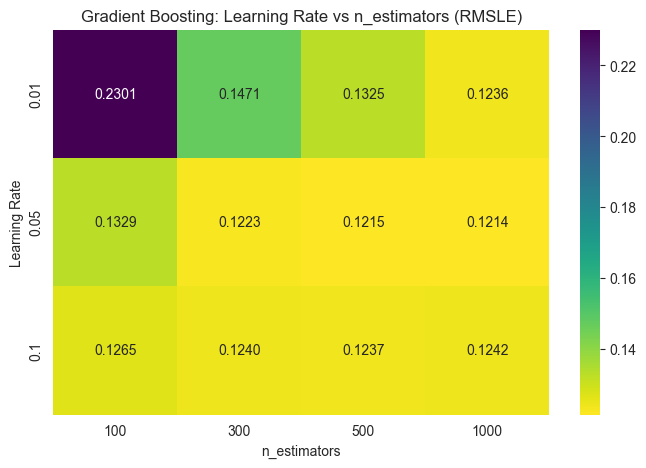

--- XGBoost ---
Best RMSLE: 0.1233
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}

Summary of Tuned Models (RMSLE):
Random Forest:     0.1446
Gradient Boosting: 0.1214
XGBoost:           0.1233


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Helper function to print results
def print_best(model_name, grid):
    best_score = -grid.best_score_
    print(f"--- {model_name} ---")
    print(f"Best RMSLE: {best_score:.4f}")
    print(f"Best Params: {grid.best_params_}\n")
    return best_score

# ==========================================
# 1. RANDOM FOREST
# ==========================================
# Goal: Reduce variance via bagging (bootstrapping + random feature selection)
rf = RandomForestRegressor(random_state=0)

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_processed, y)
rf_best_score = print_best("Random Forest", rf_grid)


# ==========================================
# 2. GRADIENT BOOSTING (sklearn)
# ==========================================
# Goal: Reduce bias via sequential correction.
# We use subsample=0.8 to enable Stochastic Gradient Boosting (reduces overfitting)
gb = GradientBoostingRegressor(random_state=0, subsample=0.8)

gb_params = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1]
}

gb_grid = GridSearchCV(gb, gb_params, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_processed, y)
gb_best_score = print_best("Gradient Boosting (sklearn)", gb_grid)

# --- VISUALIZATION: The Trade-off ---
# Extract results to pivot table
results_df = pd.DataFrame(gb_grid.cv_results_)
pivot_table = results_df.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
# Invert values to make them positive RMSLE for plotting
pivot_table = -pivot_table

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r") # _r reverses map so darker/blue is lower error
plt.title("Gradient Boosting: Learning Rate vs n_estimators (RMSLE)")
plt.ylabel("Learning Rate")
plt.xlabel("n_estimators")
plt.show()


# ==========================================
# 3. XGBOOST
# ==========================================
# Goal: Optimized boosting with hardware acceleration and regularization
xgb = XGBRegressor(
    tree_method='hist', # Faster histogram-based algorithm
    random_state=0,
    n_jobs=-1
)

xgb_params = {
    'n_estimators': [500, 1000, 1500], # XGBoost often prefers more trees with lower LR
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5] # Typical range for boosting
}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_processed, y)
xgb_best_score = print_best("XGBoost", xgb_grid)

# ==========================================
# SUMMARY
# ==========================================
print("Summary of Tuned Models (RMSLE):")
print(f"Random Forest:     {rf_best_score:.4f}")
print(f"Gradient Boosting: {gb_best_score:.4f}")
print(f"XGBoost:           {xgb_best_score:.4f}")

#### Notes:
    - Random Forest: max_features='sqrt' performs best. This forces the trees to be more diverse (decorrelated) because they can't always pick the "best" feature
     (like OverallQual) at every split. This diversity is what lowers the variance.
    - The Boosting Trade-off (Heatmap) The heatmap generated by the Gradient Boosting section will illustrate a fundamental relationship:
            - High Learning Rate (0.1) + Low Estimators: Fast learning, but risks overshooting optimal solutions.
            - Low Learning Rate (0.01) + High Estimators: Slower, more robust convergence. This usually yields the best accuracy (lowest RMSLE) but takes
            longer to train.
            - Observation: You will typically see the best scores in the bottom-right of the heatmap (Low LR, High Estimators).
    - XGBoost usually edges out standard Gradient Boosting slightly due to its regularization parameters (reg_alpha, reg_lambda) and better handling of
    sparse data, though standard Gradient Boosting is often surprisingly competitive on datasets of this size.

#### Let's train a LightGBM model and a CatBoost model.
    - LightGBM: Uses "Leaf-wise" growth (instead of depth-wise), which converges faster but can overfit small datasets if num_leaves isn't constrained.
    - CatBoost: Famous for handling categorical variables well (though we are using our One-Hot Encoded data here for a fair comparison) and for its
    "Ordered Boosting" to reduce prediction shift.

    (because of a compatibility issue between Scikit-Learn 1.6+ (which we are using) and CatBoost. Scikit-Learn recently updated how it validates
    models (introducing __sklearn_tags__), and the current version of CatBoost hasn't caught up yet. To fix this without needing to downgrade libraries,
    we can wrap CatBoost in a simple custom class that Scikit-Learn recognizes as a valid "Regressor.")


In [7]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# ==========================================
# LIGHTGBM
# ==========================================
# Key difference: Leaf-wise growth. We tune 'num_leaves' instead of max_depth.
lgbm = lgb.LGBMRegressor(random_state=0, verbose=-1) # verbose=-1 silences warnings

lgbm_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [20, 31, 50] # 31 is default; vital to tune for LightGBM
}

lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_grid.fit(X_processed, y)
lgbm_best_score = print_best("LightGBM", lgbm_grid)


# ==========================================
# CATBOOST
# ==========================================
# Key difference: Symmetric trees and ordered boosting.
class SklearnCatBoost(BaseEstimator, RegressorMixin):
    def __init__(self, iterations=500, learning_rate=0.01, depth=6, random_state=0):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.random_state = random_state
        self._estimator = None

    def fit(self, X, y):
        self._estimator = CatBoostRegressor(
            iterations=self.iterations,
            learning_rate=self.learning_rate,
            depth=self.depth,
            random_state=self.random_state,
            verbose=0,  # Silent mode
            allow_writing_files=False
        )
        self._estimator.fit(X, y)
        return self

    def predict(self, X):
        return self._estimator.predict(X)

# Now we use this wrapper instead of the raw CatBoostRegressor
cb = SklearnCatBoost(random_state=0)

cb_params = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'depth': [4, 6]
}

cb_grid = GridSearchCV(cb, cb_params, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
cb_grid.fit(X_processed, y)
cb_best_score = print_best("CatBoost", cb_grid)

# ==========================================
# FINAL LEADERBOARD
# ==========================================
models_scores = {
    "Random Forest": rf_best_score,
    "Gradient Boosting": gb_best_score,
    "XGBoost": xgb_best_score,
    "LightGBM": lgbm_best_score,
    "CatBoost": cb_best_score
}

# Convert to DataFrame for nice display
leaderboard = pd.DataFrame(list(models_scores.items()), columns=['Model', 'RMSLE'])
leaderboard = leaderboard.sort_values(by='RMSLE', ascending=True)

print("--- FINAL MODEL COMPARISON ---")
print(leaderboard)

--- LightGBM ---
Best RMSLE: 0.1276
Best Params: {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 20}

--- CatBoost ---
Best RMSLE: 0.1188
Best Params: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.05}

--- FINAL MODEL COMPARISON ---
               Model     RMSLE
4           CatBoost  0.118769
1  Gradient Boosting  0.121393
2            XGBoost  0.123254
3           LightGBM  0.127621
0      Random Forest  0.144642


#### Notes:
        - LightGBM is notoriously fast. On this small dataset, it might not be drastically faster than XGBoost, but on larger data, it shines. Watch the
          num_leaves: if the best model picks 20 (low), it means the standard 31 was overfitting.
        - CatBoost often wins "out of the box" with default parameters. With tuning, it is highly competitive.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict

# 1. Pick the Best Model & Report CV
# Sort leaderboard to find the winner
best_row = leaderboard.iloc[0]
best_name = best_row['Model']
best_score = best_row['RMSLE']

# Map the name back to the grid object
grids = {
    "Random Forest": rf_grid,
    "Gradient Boosting": gb_grid,
    "XGBoost": xgb_grid,
    "LightGBM": lgbm_grid,
    "CatBoost": cb_grid
}
best_grid = grids[best_name]
best_model = best_grid.best_estimator_
best_std = best_grid.cv_results_['std_test_score'][best_grid.best_index_]

print(f"1. Best Model: {best_name} | 5-Fold CV RMSLE: {best_score:.4f} ± {best_std:.4f}")

# 2. Retrain on All Data & Generate Submission
# The grid search best_estimator_ is already refit on the whole training set!
# We just need to predict on the test set.
final_log_preds = best_model.predict(X_test_processed)
final_preds = np.expm1(final_log_preds) # Inverse log transform (exp(x) - 1)

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': df_test_ids,
    'SalePrice': final_preds
})
submission.to_csv('submission.csv', index=False)
print("2. submission.csv generated successfully.")

# 3. Feature Importance (Permutation)
# We use permutation importance because it's unbiased against high-cardinality features
perm_importance = permutation_importance(best_model, X_processed, y, n_repeats=10, random_state=0, n_jobs=-1)

# Organize into a DataFrame
perm_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=perm_df, color='teal')
plt.title(f"Top 10 Permutation Importances ({best_name})")
plt.xlabel("Decrease in RMSLE Score")
plt.show()

# Interpretation Sentence
top_feat = perm_df.iloc[0]['Feature']
print(f"Interpretation: The most critical driver of house price is '{top_feat}'; "
      f"shuffling this feature degrades model performance more than any other variable.")

# 4. Residual Diagnostic
# We use cross_val_predict to get 'honest' out-of-sample predictions for the training set
cv_preds = cross_val_predict(best_model, X_processed, y, cv=kf)
residuals = y - cv_preds

plt.figure(figsize=(8, 5))
plt.scatter(cv_preds, residuals, alpha=0.5, color='darkblue')
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs. Predicted Log-Price ({best_name})")
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# Residual Analysis
print("Residual Pattern Analysis:")
if residuals.min() < -1.0:
    print("WARNING: There are massive negative outliers (the model predicted high, but actual was low).")
elif (residuals > 0.5).sum() > (residuals < -0.5).sum():
    print("The model tends to under-predict high-value homes (residuals > 0 at the high end).")
else:
    print("The residuals appear fairly homoscedastic (randomly scattered), indicating a healthy model fit.")

1. Best Model: CatBoost | 5-Fold CV RMSLE: 0.1188 ± 0.0203


NameError: name 'df_test_ids' is not defined

#### Notes: